# 1. 데이터 확인

## 1-1. 리스트 확인

In [1]:
import os

# sticker list
sticker_path = './data/sticker'
for file in os.listdir(sticker_path):
    if '.ipynb_checkpoints' == file:
        os.rmdir(f'{sticker_path}/{file}')
print(os.listdir(sticker_path))

# image list
img_path = './data/img'
for file in os.listdir(img_path):
    if '.ipynb_checkpoints' == file:
        os.rmdir(f'{img_path}/{file}')
print(os.listdir(img_path))

# model
model_path = './data/model'
for file in os.listdir(model_path):
    if '.ipynb_checkpoints' == file:
        os.rmdir(f'{model_path}/{file}')
print(os.listdir(model_path))

['cat-whiskers.png']
['4.jpg', '2.jpg', '5.jpg', '3.jpg', '6.jpg', '1.jpg']
['shape_predictor_68_face_landmarks.dat']


## 1-2. 이미지 확인

In [2]:
import cv2
import matplotlib.pyplot as plt

def get_img(path):
    return cv2.imread(path)

def show_img(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

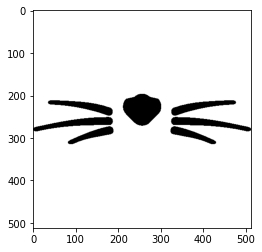

In [3]:
for sticker in os.listdir(sticker_path):
    img = get_img(f'{sticker_path}/{sticker}')
    show_img(img)

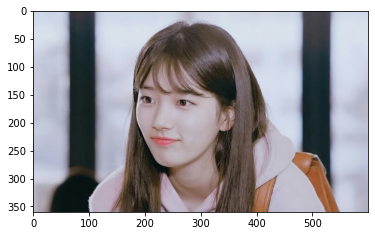

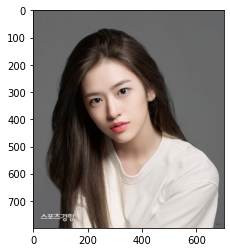

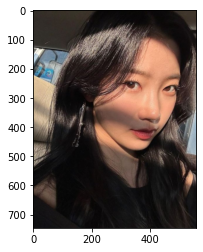

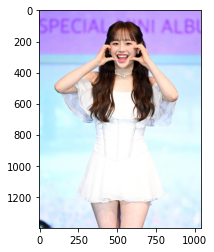

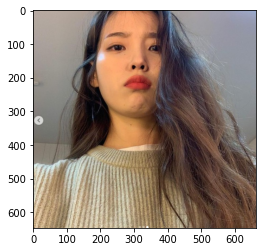

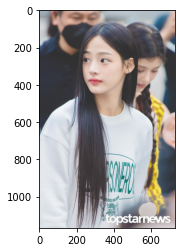

In [4]:
for img in os.listdir(img_path):
    img = get_img(f'{img_path}/{img}')
    show_img(img)

# 2. 카메라 스티커 앱 구현

## 2-1. 얼굴 위치 확인

In [5]:
import dlib

# detector
detector_hog = dlib.get_frontal_face_detector()


def get_face_bounding_box(img):
    return detector_hog(img, 1)
    
    
def set_face_bounding_box(img, dlib_rects):
    
    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()

        cv2.rectangle(img, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

    return img

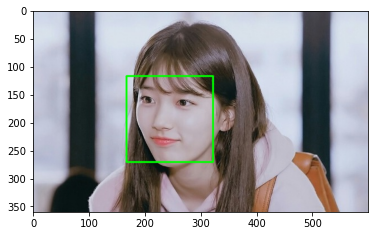

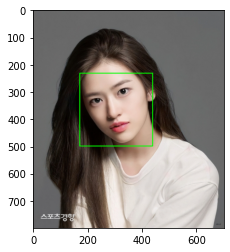

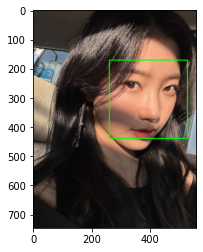

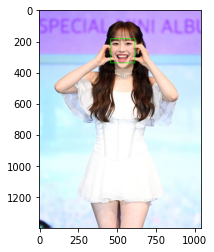

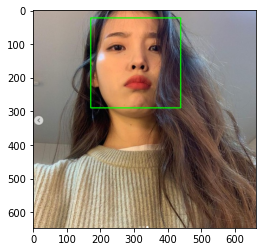

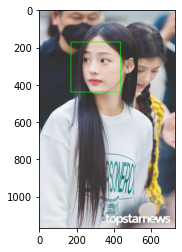

In [6]:
for img in os.listdir(img_path):
    img = get_img(f'{img_path}/{img}')
    dlib_rects = get_face_bounding_box(img)
    img = set_face_bounding_box(img, dlib_rects)
    show_img(img)

## 2-2. Landmark 확인

In [7]:
# predictor
landmark_predictor = dlib.shape_predictor(f'{model_path}/shape_predictor_68_face_landmarks.dat')

def get_landmarks(img, dlib_rects):
    
    def get_points(dlib_rect):
        points = landmark_predictor(img, dlib_rect)
        return list(map(lambda it: (it.x, it.y), points.parts()))
    
    return list(map(get_points, dlib_rects))

def set_landmarks(img, landmarks):
    for landmark in landmarks:
        for point in landmark:
            cv2.circle(img, point, 2, (0, 255, 255), -1)
    return img

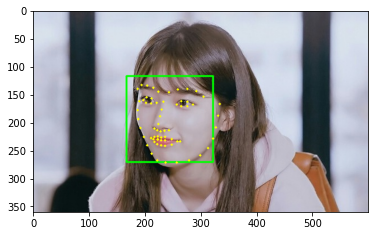

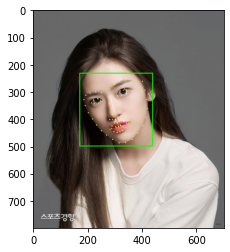

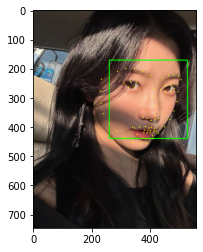

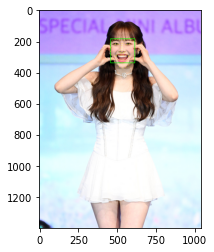

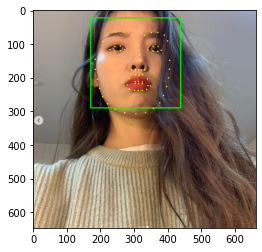

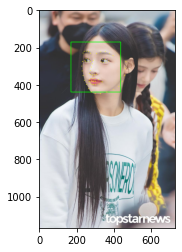

In [8]:
for img in os.listdir(img_path):
    img = get_img(f'{img_path}/{img}')

    dlib_rects = get_face_bounding_box(img)
    img = set_face_bounding_box(img, dlib_rects)

    landmarks = get_landmarks(img, dlib_rects)
    img = set_landmarks(img, landmarks)

    show_img(img)

## 2-3. 스티커 적용

In [9]:
import numpy as np
import math

def set_sticker(img, dlib_rects, landmarks):
    
    # 점과 점 사이의 각도를 구해서 이미지의 가운데 기준으로 각도만큼 스티커를 회전시킨다
    def rotate_image(image, start, end):
        dx = end[0] - start[0]
        dy = end[1] - start[1]
        
        # angle = math.atan2(dy, dx)
        tan_theta = dx / dy
        theta = np.arctan(tan_theta)

        angle = theta * (180.0 / math.pi)
        
        image_center = tuple(np.array(image.shape[1::-1]) / 2)
        rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
        return cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR,borderValue=(255,255,255))
    
    
    for dlib_rect, landmark in zip(dlib_rects, landmarks):
        x = landmark[30][0]
        y = landmark[30][1] - dlib_rect.height() // 2 
        w = h = dlib_rect.width()
        
        img_sticker = cv2.imread(f'{sticker_path}/cat-whiskers.png')
        img_sticker = cv2.resize(img_sticker, (w,h))
        
        refined_x = x - w // 2
        refined_y = y + 10
        
        if refined_x < 0: 
            img_sticker = img_sticker[:, -refined_x:]
            refined_x = 0
            
        if refined_y < 0:
            img_sticker = img_sticker[-refined_y:, :]
            refined_y = 0
            
        start = landmark[30] # 코
        end = landmark[27]   # 미간
        img_sticker = rotate_image(img_sticker, start, end)
            
        sticker_area = img[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]]
        img[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]] = \
            cv2.addWeighted(
                sticker_area, 
                0, 
                np.where(img_sticker==0, img_sticker, sticker_area).astype(np.uint8), 1, 0)
    
    return img

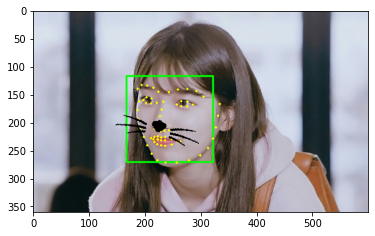

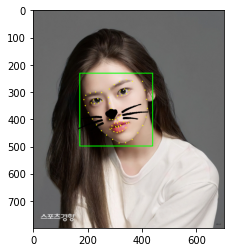

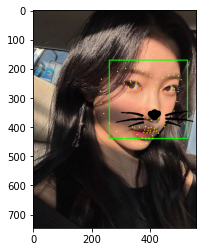

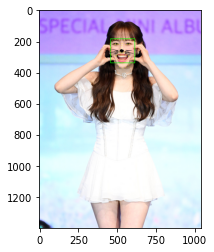

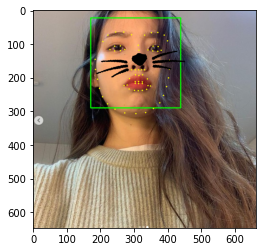

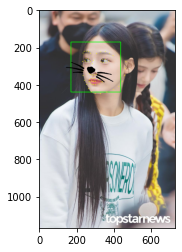

In [10]:
for img in os.listdir(img_path):
    img = get_img(f'{img_path}/{img}')

    dlib_rects = get_face_bounding_box(img)
    img = set_face_bounding_box(img, dlib_rects)

    landmarks = get_landmarks(img, dlib_rects)
    img = set_landmarks(img, landmarks)

    img = set_sticker(img, dlib_rects, landmarks)

    show_img(img)

## 2-4. bounding Box와 landmark 제거

In [102]:
def show_camera_sticker(path, bounding_box=False, landmark=False):
    img = get_img(path)

    dlib_rects = get_face_bounding_box(img)
    if bounding_box:
        img = set_face_bounding_box(img, dlib_rects)

    landmarks = get_landmarks(img, dlib_rects)
    if landmark:
        img = set_landmarks(img, landmarks)

    img = set_sticker(img, dlib_rects, landmarks)

    show_img(img)

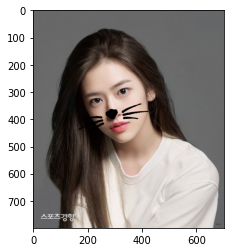

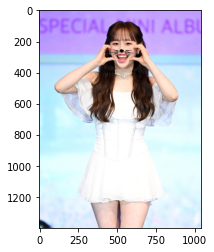

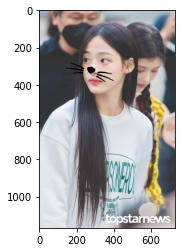

In [103]:
for img in os.listdir(img_path):
    show_camera_sticker(f'{img_path}/{img}')

> 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
- x, y축으로 회전뿐 아니라 z축 회전까지 고려해서 스티커를 붙여줘야 할 것 같음
- landmark 정보로 스티커를 이미지를 어떻게 transform 시켜줘야 할지 나오는 모델을 만들 수 있지 않을까?

> 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
- 모델이 얼굴을 찾지 못할것 같음, 다양한 트레이닝 데이터로 학습된 디텍팅 모델을 사용해야할 것 같음

> 실행 속도가 중요할까요?
- 실시간으로 서비스가 되어야 하는 제품이라면 실행속도가 중요함

> 스티커앱을 만들 때 정확도가 얼마나 중요할까요?
- 매우 중요함, 스티커 앱을 만든다는건 사진에서 얼굴 인식 및 얼굴의 landmark를 찾을 수 있다는 전제 하에 성립함